# YikYak Topic Modeling, Sentiment and Cyberbullying Analysis

----

# Table of Contents

<ul>
<li><a href="#Imports">Imports</a></li>
<li><a href="#Read-the-data">Read the data</a><ul style="margin:0">
<li><a href="#Normalize-Function">Normalize Function</a></li>
<li><a href="#Prepare-data">Prepare data</a></li>
</ul>
</li>
<li><a href="#EDA">EDA</a></li>
<li><a href="#Topic-Modeling">Topic Modeling</a><ul style="margin:0">
<li><a href="#Bag-of-words">Bag of words</a></li>
<li><a href="#TF-IDF">TF-IDF</a></li>
</ul>
</li>
<li><a href="#Classifying-Bullying-Trace">Classifying Bullying Trace</a></li>
<li><a href="#Sentiment-Analysis">Sentiment Analysis</a></li>
<li><a href="#Word-Cloud">Word Cloud</a></li>
</ul>

# Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np

# setup for tokenization and stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from gensim import corpora, models, similarities
import re
from bs4 import BeautifulSoup
import contractions
import unicodedata

import gensim
import pyLDAvis.gensim

import pandas as pd

from datetime import datetime

import subprocess
import os

import matplotlib.pyplot as plt

from scipy import stats

# Read the data

In [3]:
df = pd.read_csv('./data/yaks.csv',parse_dates=['timestamp'])
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6633 entries, 0 to 6632
Data columns (total 7 columns):
yak_id           6633 non-null object
user_id          6633 non-null object
post_contents    6633 non-null object
score            6633 non-null int64
latitue          6633 non-null float64
longitude        6633 non-null float64
timestamp        6633 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 362.8+ KB
None


,yak_id,user_id,post_contents,score,latitue,longitude,timestamp
0,R/54b705a67b0d579d657138442156b,54b9505b467d4,upvote.,42,42.815096,-77.833656,2015-01-14 19:11:18
1,R/54b700744579a56e8a3e81a76238c,54b9505b46882,I skipped all the suspense and just bought mys...,21,42.782899,-77.824663,2015-01-14 18:49:08
2,R/54b43524c26981ecfe2f665646c50,54b9505b46fec,How could I live without Wegmans,21,42.820356,-77.781153,2015-01-12 15:57:08
3,R/54b5de2c7670b2f6a02d0aeaec243,54b9505b46c8d,Why do we live where the air hurts your face?,16,42.808792,-77.827142,2015-01-13 22:10:36
4,R/54b6efe2e5b9e84c29aac56688259,54b9505b469d6,Anyone else looking forward to the new season ...,15,42.804032,-77.828611,2015-01-14 17:38:26
5,R/54b84f6b185568502f9c32f086f65,54b9505b458f1,Welcome to Geneseo transfers. We pride ourselv...,14,42.791956,-77.817910,2015-01-15 18:38:19
6,R/54b80fb10dac285ddb67fe40b295d,54b9505b45f08,'Where's the red one with the sickle and hamme...,14,42.815852,-77.821682,2015-01-15 14:06:25
7,R/54b5e2f72c02b2253c4f7a46b46d7,54b9505b46be0,Literally watching a show called big giant swo...,13,42.785129,-77.811152,2015-01-13 22:31:03
8,R/54b806af522330ed9962283fccbb2,54b9505b45fb6,Only person in my suite for the next few days....,12,42.819234,-77.820048,2015-01-15 13:27:59
9,R/54b8953e210c26760c6029492c067,54b9505b44ecf,roommates are coming back soon which means I h...,8,42.782657,-77.822605,2015-01-15 23:36:14


In [4]:
df[['post_contents', 'timestamp']].head()

,post_contents,timestamp
0,upvote.,2015-01-14 19:11:18
1,I skipped all the suspense and just bought mys...,2015-01-14 18:49:08
2,How could I live without Wegmans,2015-01-12 15:57:08
3,Why do we live where the air hurts your face?,2015-01-13 22:10:36
4,Anyone else looking forward to the new season ...,2015-01-14 17:38:26


In [5]:
df['timestamp'].describe()

count                    6633
unique                   6613
top       2015-03-02 01:08:32
freq                        2
first     2015-01-12 15:57:08
last      2015-03-04 12:09:42
Name: timestamp, dtype: object

In [29]:
date_min = pd.Timestamp(datetime(2015, 2, 8, 0, 0, 0))
#date_max = pd.Timestamp(datetime(2015, 2, 20, 23, 59, 59))
date_max = pd.Timestamp(datetime(2015, 2, 16, 0, 0, 0))

df2 = df[(df['timestamp'] >= date_min) & (df['timestamp'] < date_max)]
print("Total count", len(df2))
df2.head(10)

Total count 246


,yak_id,user_id,post_contents,score,latitue,longitude,timestamp
3318,R/54d6f171ac39cc28cca6a52bce09b,54d74668461ce,Freedom non-boner,5,42.80,-77.83,2015-02-08 00:17:37
3319,R/54d6f1ecd6474b2876d1717c2cfbf,54d746684611e,Those thirsty Arabs,-3,42.78,-77.83,2015-02-08 00:19:40
3320,R/54d6f4589391678957297fbd205c7,54d748c0479df,Superbad is a god damn classic,11,42.81,-77.81,2015-02-08 00:30:00
3321,R/54d6f3d2db87d784bd33d19d114da,54d748c047a6c,Shut. The. Fuck. Up. People.,4,42.81,-77.84,2015-02-08 00:27:46
3322,R/54d6f25fcb877d7ddca751f88c658,54d748c047bd0,I just fucked whats-her-name and UOENO,3,42.81,-77.80,2015-02-08 00:21:35
3323,R/54d6f320e34055ef898f27ea635ec,54d748c047b1e,Freedom Boner!,-1,42.80,-77.81,2015-02-08 00:24:48
3324,R/54d6f5b98ce3fd665331b7f1a04f4,54d74b184b0f4,Dear pledges You might be hammered tonight but...,56,42.79,-77.80,2015-02-08 00:35:53
3325,R/54d6f7f085a879dd8c90715377395,54d74d7058a23,Well I've already seen two of my pledge sister...,10,42.82,-77.82,2015-02-08 00:45:20
3326,R/54d6f7967c192e8b493578ebf5a7f,54d74d7058ad4,It's gonna be a long night,3,42.80,-77.82,2015-02-08 00:43:50
3327,R/54d6f77076237c6bc24027572fe93,54d74d7058b85,Uhhyup,1,42.78,-77.82,2015-02-08 00:43:12


### Normalize Function

In [7]:
tokenizer = ToktokTokenizer()
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

STOP_WORDS = set(stopwords.words("english"))
STOP_WORDS.update(['.',  ',', '"', "'", '’', '&', '/', '\\', '-', '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '%'])
STOP_WORDS.update(["a","able","about","across","after","all","almost","also","am","among","an","and","any","are","as","at",
                   "be","because","been","but","by","can","cannot","could","dear","did","do","does","either","else","ever",
                   "every","for","from","get","got","had","has","have","he","her","hers","him","his","how","however",
                   "i","if","in","into","is","it","its","just","least","let","like","likely","may","me","might","most",
                   "must","my","neither","no","nor","not","of","off","often","on","only","or","other","our","own","rather",
                   "said","say","says","she","should","since","so","some","than","that","the","their","them","then","there",
                   "these","they","this","tis","to","too","twas","us","wants","was","we","were","what","when","where",
                   "which","while","who","whom","why","will","with","would","yet","you","your"])
STOP_WORDS = list(STOP_WORDS)

STEM_WORDS = False

## Cleaning Text - strip HTML
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text


## Removing accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


## Expanding Contractions
def expand_contractions(text):
    return contractions.fix(text)


## Removing Special Characters
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-z0-9\s]', '', text)
    return text


## Lemmatizing text
def stem_text(text):
    return [stemmer.stem(a) for a in text]


## Removing Stopwords
def remove_stopwords(word_list):
    return [word for word in word_list if word not in STOP_WORDS]


## Normalize text corpus - tying it all together
def normalize_corpus(corpus, html_stripping=False, contraction_expansion=True,
                     accented_char_removal=False, 
                     stem=True, special_char_removal=False, 
                     stopword_removal=True):
    
    if isinstance(corpus, str):
        corpus = [corpus]
    
    normalized_corpus = []
    
    for doc in corpus:
        
        if doc is None:
            continue
            
        doc = doc.lower()
        
        if html_stripping:
            doc = strip_html_tags(doc)
        
        if accented_char_removal:
            doc = remove_accented_chars(doc)
            
        if contraction_expansion:
            doc = expand_contractions(doc)
            
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        if special_char_removal:
            doc = remove_special_characters(doc) 
            
        doc = tokenizer.tokenize(doc)
        
        if stem:
            doc = stem_text(doc)
        
        if stopword_removal:
            doc = remove_stopwords(doc)
            
        normalized_corpus.append(' '.join(doc))
        
    return normalized_corpus[0] if (len(normalized_corpus) == 1) else normalized_corpus


### Prepare data

In [30]:
def get_parsed_comments(df):
    comments = []
    for index, row in df.iterrows():
        comments.append(row['post_contents'])
    
    results = []
    for comment in comments:
        results.append(normalize_corpus(comment, stem=STEM_WORDS).split(' '))
    return results

def get_corpra(texts):
    all_words = []
    for t in texts:
        all_words += t
        
    all_tokens = all_words
    
    # remove words that appear only once
    tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
    
    results = []
    #texts = [[words for words in texts if words not in tokens_once] for words in all_tokens]
    i = 0
    for text in texts:
        r = []
        for t in text:
            if t not in tokens_once and t:
                r.append(t)
        if len(r) > 0:
            results.append(r)
    
    return results


texts = get_parsed_comments(df2)
texts = get_corpra(texts)
texts

[['freedom'],
 ['god', 'classic'],
 ['fuck', 'people'],
 ['fucked'],
 ['freedom'],
 ['pledges', 'tonight', 'next', '6', 'weeks', 'fun'],
 ['well', 'already', 'two', 'pledge', 'tonight', 'going', 'great', 'semester'],
 ['going', 'long', 'night'],
 ['congrats', 'pledges', 'friends'],
 ['show', 'things'],
 ['pledges', 'fun', 'next', '6', 'weeks'],
 ['sports', 'greek', 'life', 'day', 'better', 'drama'],
 ['see', 'person', 'wanted', 'see', 'long', 'time', 'want'],
 ['family', 'perfect', 'love', 'perfect', 'little', 'life'],
 ['need', 'someone', 'sleep'],
 ['probably', 'leave', 'go', 'bed'],
 ['think', 'guy', 'good'],
 ['much',
  'people',
  'go',
  'good',
  'time',
  'without',
  'paying',
  'dues',
  'semester'],
 ['need', 'daga', 'snuggle', 'buddy'],
 ['wish', 'ur', 'alcoholic', 'mom', 'leave', 'family', 'alone'],
 ['lesbian', 'looking', 'try', 'dick', 'first', 'time'],
 ['dad', 'away', 'mom', 'home', 'alone', 'feel'],
 ['look', 'go'],
 ['geneseo', 'alone', 'long'],
 ['wish',
  'love',
 

# EDA

In [9]:
def get_all_yaks(df):
    comments = []
    for index, row in df.iterrows():
        comments.append(row['post_contents'])
    return comments

all_yaks = get_all_yaks(df)
num_characters = np.array([len(yak) for yak in all_yaks])
num_words = np.array([len(yak.split(' ')) for yak in all_yaks])

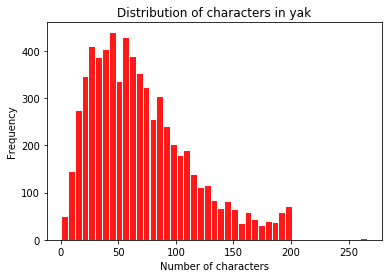

DescribeResult(nobs=6633, minmax=(1, 266), mean=69.82632293080054, variance=1847.3947412569785, skewness=0.9444439039622454, kurtosis=0.5451726410780102)

In [22]:
plt.hist(num_characters, bins='auto', color='red', alpha=0.9, rwidth=0.85)
plt.title('Distribution of characters in yak')
plt.ylabel('Frequency');
plt.xlabel('Number of characters');
plt.show()
plt.close()

stats.describe(num_characters)

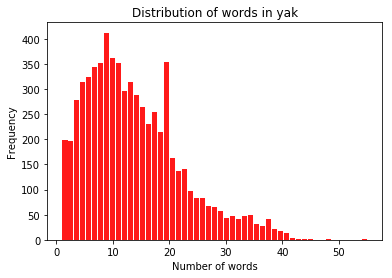

DescribeResult(nobs=6633, minmax=(1, 55), mean=13.78818031056837, variance=69.97729091320092, skewness=0.9333202315389606, kurtosis=0.6141180862936952)

In [23]:
plt.hist(num_words, bins='auto', color='red', alpha=0.9, rwidth=0.85)
plt.title('Distribution of words in yak')
plt.ylabel('Frequency');
plt.xlabel('Number of words');
plt.show()
plt.close()

stats.describe(num_words)

# Topic Modeling

In [12]:
def get_terms_only(s):
    s = s.replace('+', '')
    s = s.replace('-', '')
    s = s.replace('.', '')
    s = s.replace('*', '')
    s = s.replace('/', '')
    s = ''.join([i for i in s if not i.isdigit()])
    s = s.split('"')
    return [x for x in s if x.strip()]

### Bag of words

In [31]:
# Setup gensim dictionary
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
#corpora.MmCorpus.serialize('reddit.mm', corpus)
#print(corpus)

lda = gensim.models.LdaModel(corpus, id2word=dictionary, alpha='auto', num_topics=10, random_state=12345)

for topic in lda.show_topics():
    #print(topic)
    print(get_terms_only(topic[1]))
    
topic_vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
pyLDAvis.display(topic_vis)

['much', 'fuck', 'girl', 'want', 'think', 'anyone', 'tight', 'good', 'ten', 'hot']
['need', 'girls', 'one', 'want', 'life', 'night', 'trying', 'kiss', 'accidentally', 'plans']
['know', 'life', 'feel', 'please', 'fix', 'want', 'day', 'still', 'fucked', 'really']
['night', 'know', 'still', 'even', 'sleep', 'day', 'last', 'period', 'week', 'bids']
['first', 'chipotle', 'feelings', 'time', 'try', 'talk', 'times', 'girl', 'sex', 'today']
['night', 'guys', 'going', 'last', 'go', 'friends', 'girl', 'saw', 'semester', 'people']
['even', 'alone', 'go', 'want', 'weird', 'home', 'sex', 'girls', 'away', 'late']
['go', 'shit', 'friends', 'make', 'statesmen', 'guy', 'want', 'someone', 'tired', 'think']
['love', 'people', 'still', 'go', 'sometimes', 'shower', 'need', 'night', 'really', 'anorexia']
['people', 'much', 'life', 'someone', 'hate', 'long', 'fun', 'alone', 'know', 'love']


### TF-IDF

In [32]:
from gensim.models import TfidfModel

# Setup gensim dictionary
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
#corpora.MmCorpus.serialize('reddit.mm', corpus)
#print(corpus)

#tfidf = TfidfModel(corpus)
tfidf = TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]
#print(corpus_tfidf)

lda = gensim.models.LdaModel(corpus_tfidf, id2word=dictionary, alpha='auto', num_topics=10, random_state=12345)
for topic in lda.show_topics():
    #print(topic)
    print(get_terms_only(topic[1]))
    
topic_vis = pyLDAvis.gensim.prepare(lda, corpus_tfidf, dictionary)
pyLDAvis.display(topic_vis)

['fuck', 'geneseo', 'think', 'much', 'apo', 'rush', 'girl', 'anyone', 'tight', 'okay']
['girls', 'need', 'life', 'one', 'love', 'never', 'want', 'help', 'shit', 'fucking']
['please', 'everyone', 'fix', 'hot', 'feel', 'daga', 'back', 'coming', 'sit', 'face']
['know', 'still', 'night', 'bids', 'anyone', 'waiting', 'week', 'day', 'period', 'think']
['worst', 'times', 'first', 'today', 'want', 'drunk', 'sex', 'wear', 'feelings', 'chipotle']
['night', 'balls', 'go', 'last', 'new', 'fuck', 'freedom', 'look', 'girl', 'going']
['party', 'mom', 'even', 'things', 'everyone', 'found', 'college', 'guy', 'alone', 'sex']
['taste', 'friends', 'go', 'want', 'guy', 'mom', 'love', 'supposed', 'statesmen', 'make']
['day', 'sunday', 'hope', 'freedom', 'love', 'go', 'watching', 'want', 'wish', 'shit']
['food', 'fucked', 'long', 'bed', 'hate', 'much', 'already', 'everyone', 'actually', 'dick']


# Classifying Bullying Trace

Classifier: http://research.cs.wisc.edu/bullying/data.html

```Learning from bullying traces in social media
Jun-Ming Xu, Kwang-Sung Jun, Xiaojin Zhu, and Amy Bellmore
In North American Chapter of the Association for Computational Linguistics - Human Language Technologies (NAACL HLT)
Montreal, Canada, 2012```

In [15]:
def build_path(relative_path):
    path = os.getcwd() + '/' + relative_path
    return os.path.abspath(path)

Build the JAR files necessary to run the classifier

In [16]:
def build_jars():
    make_path = build_path('./cyberbullying_classifier/bullyingtraceV2/Makefile')
    cwd = build_path('./cyberbullying_classifier/bullyingtraceV2/')
    p = subprocess.Popen(['sh', make_path], cwd=cwd)
    p.wait()
    
build_jars()

Write all the comments to file

In [17]:
COMMENTS_PATH = build_path('./data/only_comments.txt')

def write_comments_to_textfile(df, filename):
    comments = []
    
    # Read all comments from dataframe
    for index, row in df.iterrows():
        comments.append(row['post_contents'])
        
    # Write to file
    with open(filename, 'w') as f:
        for item in comments:
            f.write("%s\n" % item)

write_comments_to_textfile(df, COMMENTS_PATH)

In [18]:
def write_contents_to_file(contents, file_path):
    with open(file_path, 'w') as f:
        f.write(contents)
    
def run_classifier(clf_type, comments_path, save_location):
    #cat test_filtered.txt | java -jar Classification.jar trace > bullying_trace.txt
    jar_path = build_path('./cyberbullying_classifier/bullyingtraceV2/Classification.jar')
    p1 = subprocess.Popen(["cat", comments_path], stdout=subprocess.PIPE)
    p2 = subprocess.Popen(["java", "-jar", jar_path, clf_type], stdin=p1.stdout, stdout=subprocess.PIPE)
    p1.stdout.close()
    out, err = p2.communicate()
    write_contents_to_file(out.decode("utf-8") , build_path(save_location + '/bullying_' + clf_type + '_results.txt'))
    if err:
        print(err)
    print('Finished running classifier =', clf_type)

# Trace of bullying
run_classifier('trace', COMMENTS_PATH, './data/')

# Teasing
run_classifier('teasing', COMMENTS_PATH, './data/')

# Type
run_classifier('type', COMMENTS_PATH, './data/')

# Form of bullying
run_classifier('form', COMMENTS_PATH, './data/')

Finished running classifier = trace
Finished running classifier = teasing
Finished running classifier = type
Finished running classifier = form


In [33]:
def get_file_contents(fp):
    with open(fp, 'r') as file:
        data = file.read()
    return data

In [44]:
teasing = get_file_contents('./data/bullying_teasing_results.txt').strip()
teasing_yes = np.sum([1 for t in teasing.split('\n') if t.lower() == 'yes'])
teasing_no = np.sum([1 for t in teasing.split('\n') if t.lower() != 'yes'])
teasing_yes, teasing_no

(583, 6052)

In [58]:
583/(6052+583)

0.08786737000753579

In [45]:
trace = get_file_contents('./data/bullying_trace_results.txt').strip()
trace_yes = np.sum([1 for t in trace.split('\n') if t.lower() == 'yes'])
trace_no = np.sum([1 for t in trace.split('\n') if t.lower() != 'yes'])
trace_yes, trace_no

(3081, 3554)

In [59]:
3081/(3081+3554)

0.4643556895252449

In [43]:
bullying_from = get_file_contents('./data/bullying_form_results.txt').strip()
bullying_from_yes = np.sum([1 for t in bullying_from.split('\n') if t.lower() != 'general'])
bullying_from_no = np.sum([1 for t in bullying_from.split('\n') if t.lower() == 'general'])
bullying_from_yes, bullying_from_no

(1259, 5376)

In [60]:
1259/(1259+5376)

0.18975131876412962

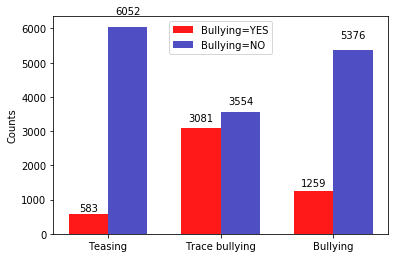

In [61]:
N = 3
men_means = (583, 3081, 1259)

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, men_means, width, color='red', alpha=0.9)

women_means = (6052, 3554, 5376)
rects2 = ax.bar(ind + width, women_means, width, color='#0504aa', alpha=0.7)

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Teasing', 'Trace bullying', 'Bullying'))

ax.legend((rects1[0], rects2[0]), ('Bullying=YES', 'Bullying=NO'))


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height, '%d' % int(height), ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()
plt.close()

# Sentiment Analysis

In [19]:
from sklearn.linear_model import LogisticRegression
import pickle 

with open('./sentiment_classifier/sent140.pkl', 'rb') as fid:
    sent_clf = pickle.load(fid)
    
with open('./sentiment_classifier/vectorizer.pkl', 'rb') as fid:
    vectorizer = pickle.load(fid)

In [20]:
texts2 = []
for t in texts:
    texts2.append(' '.join(t))

d = vectorizer.transform(texts2)
preds = sent_clf.predict(d)
print("Positive", np.sum(preds))
print("Negative", len(preds) - np.sum(preds))

Positive 3111
Negative 3396


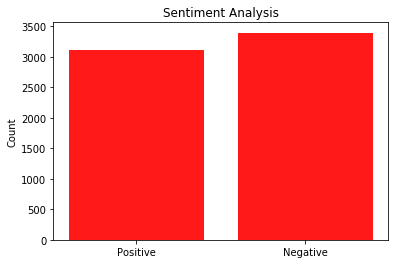

In [46]:
objects = ('Positive', 'Negative')
y_pos = np.arange(len(objects))
performance = [3111, 3396]

plt.bar(y_pos, performance, align='center', color='red', alpha=0.9)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Sentiment Analysis')

plt.show()
plt.close()

# Word Cloud

In [26]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

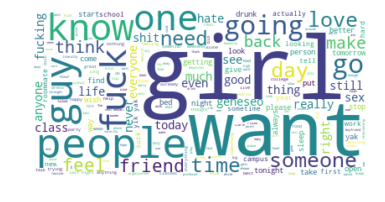

In [28]:
wordcloud = WordCloud(background_color="white").generate(' '.join(texts2))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()